# Classificação CIFAR 10 com Pytorch

## Importação de bibliotecas

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split

## Carregamento do dataset de imagens

In [2]:
# Carregar o dataset CIFAR-10
cifar10_dir = './cifar-10-batches-py'
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = datasets.CIFAR10(root=cifar10_dir, train=True, download=True, transform=transform)
testset = datasets.CIFAR10(root=cifar10_dir, train=False, download=True, transform=transform)

# Dividir o conjunto de treino para treinamento e validação
train_size = int(0.9 * len(trainset))
valid_size = len(trainset) - train_size
train_data, valid_data = random_split(trainset, [train_size, valid_size])

trainloader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=4)
validloader = DataLoader(valid_data, batch_size=64, shuffle=False, num_workers=4)
testloader = DataLoader(testset, batch_size=64, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


### Dimensionamento

In [3]:
# Obter tamanhos dos conjuntos de dados
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(testset)

# Exibir tamanhos dos conjuntos
print(f'Train Images Shape:      {train_size} samples')
print(f'Validation Images Shape: {valid_size} samples')
print(f'Test Images Shape:       {test_size} samples')

Train Images Shape:      45000 samples
Validation Images Shape: 5000 samples
Test Images Shape:       10000 samples


## Visualização do Dataset

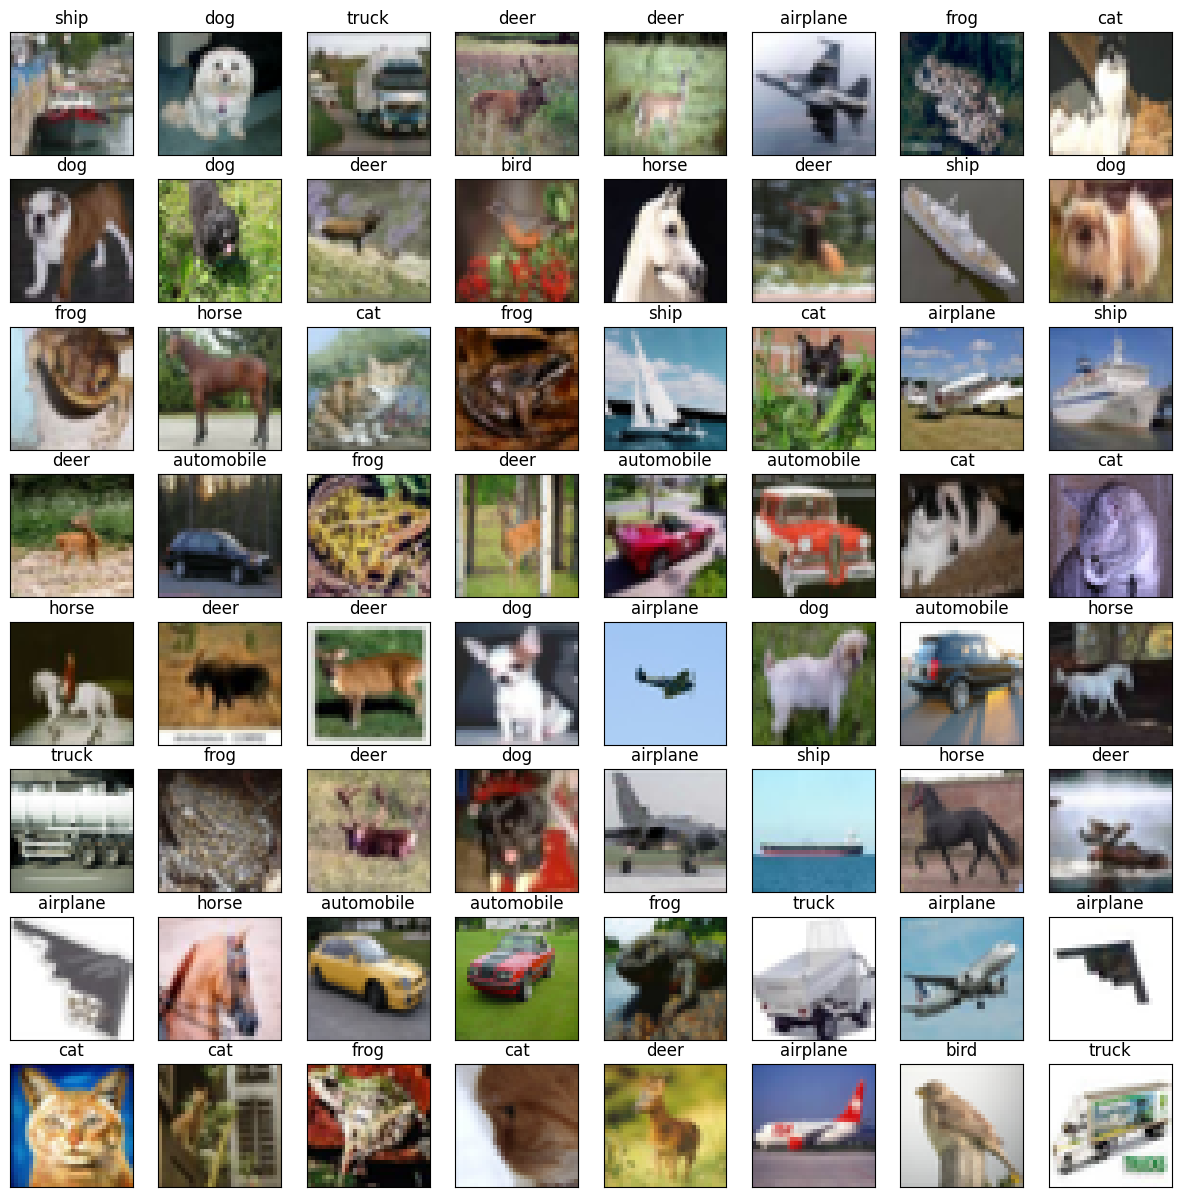

In [4]:
# CIFAR-10 classes
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Obter um lote de dados do DataLoader
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Normalizar as imagens para o intervalo [0, 1] para visualização
images = images / 2 + 0.5  # Desfaz a normalização feita anteriormente

# Converter imagens para numpy para uso no matplotlib
images = images.numpy()

# Criar uma nova figura
plt.figure(figsize=(15, 15))

# Loop para exibir as primeiras 64 imagens
for i in range(64):
    # Criar um subplot para cada imagem
    plt.subplot(8, 8, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # Transpor as dimensões para (altura, largura, canais) para visualização
    plt.imshow(np.transpose(images[i], (1, 2, 0)))

    # Adicionar o rótulo como título
    plt.title(class_names[labels[i].item()], fontsize=12)

# Exibir a figura
plt.show()

---
# Pré-Processamento de Dados

## Normalização

In [5]:
# Converter os dados para tensores float32 e calcular média/desvio padrão do conjunto de treinamento
train_images = torch.cat([data[0] for data in trainloader], dim=0)  # Concatena os lotes em um único tensor

mean = train_images.mean(dim=(0, 2, 3))  # Média por canal (R, G, B)
std = train_images.std(dim=(0, 2, 3))    # Desvio padrão por canal (R, G, B)

# Atualizar as transformações para incluir normalização
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])


## One-Hot Encoding dos Rótulos

In [6]:
import torch

# Codificação one-hot para os rótulos (labels) dos datasets
num_classes = 10

# Função para realizar a codificação one-hot nos rótulos de um dataloader
def one_hot_encode(labels, num_classes):
    return torch.nn.functional.one_hot(labels, num_classes=num_classes)

# Para o conjunto de treinamento
for images, labels in trainloader:
    y_train = one_hot_encode(labels, num_classes=num_classes)
    print(f"y_train shape: {y_train.shape}")
    break  # Apenas para mostrar a primeira batch (pode remover isso para processar todos os batches)

# Para o conjunto de validação
for images, labels in validloader:
    y_valid = one_hot_encode(labels, num_classes=num_classes)
    print(f"y_valid shape: {y_valid.shape}")
    break  # Apenas para mostrar a primeira batch (pode remover isso para processar todos os batches)

# Para o conjunto de teste
for images, labels in testloader:
    y_test = one_hot_encode(labels, num_classes=num_classes)
    print(f"y_test shape: {y_test.shape}")
    break  # Apenas para mostrar a primeira batch (pode remover isso para processar todos os batches)

y_train shape: torch.Size([64, 10])
y_valid shape: torch.Size([64, 10])
y_test shape: torch.Size([64, 10])


## Data Augmentation

In [7]:
import torchvision.transforms as transforms

# Data augmentation com transformações semelhantes ao TensorFlow
train_transform = transforms.Compose([
    # Rotacionar imagens aleatoriamente em até 15 graus
    transforms.RandomRotation(15),
    
    # Deslocar imagens horizontalmente em até 12% de sua largura
    transforms.RandomAffine(0, translate=(0.12, 0.12)),
    
    # Inverter imagens horizontalmente aleatoriamente
    transforms.RandomHorizontalFlip(),
    
    # Ampliar imagens em até 10%
    transforms.RandomResizedCrop(32, scale=(0.9, 1.1)),
    
    # Alterar o brilho em até 10%
    transforms.ColorJitter(brightness=0.1),
    
    # Intensidade de cisalhamento (ângulo de cisalhamento no sentido anti-horário em graus)
    transforms.RandomAffine(0, shear=10),
    
    # Intensidade de deslocamento de canal
    transforms.RandomAdjustSharpness(sharpness_factor=2),
    
    # Convertendo para tensor e normalizando
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalização similar ao seu código original
])

# Aplicando ao conjunto de treinamento
trainset = datasets.CIFAR10(root=cifar10_dir, train=True, download=True, transform=train_transform)

# DataLoader para o conjunto de treino com augmentações
trainloader = DataLoader(trainset, batch_size=64, shuffle=True, num_workers=8)

Files already downloaded and verified


---
## Arquitetura do Modelo CNN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModel(nn.Module):
    def __init__(self, num_classes=10):
        super(CNNModel, self).__init__()

        # Definindo as camadas
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        # Camadas de pooling e dropout
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(p=0.2)
        self.dropout2 = nn.Dropout(p=0.3)
        self.dropout3 = nn.Dropout(p=0.4)
        self.dropout4 = nn.Dropout(p=0.5)
        
        # Camada totalmente conectada
        self.fc1 = nn.Linear(256 * 2 * 2, num_classes)  # Assumindo que a entrada seja 32x32

        # Batch Normalization
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(128)
        self.bn6 = nn.BatchNorm2d(128)
        self.bn7 = nn.BatchNorm2d(256)
        self.bn8 = nn.BatchNorm2d(256)

    def forward(self, x):
        # Passando pela primeira camada convolucional
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        x = self.dropout1(x)
        
        # Passando pela segunda camada convolucional
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.maxpool(x)
        x = self.dropout2(x)
        
        # Passando pela terceira camada convolucional
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = self.maxpool(x)
        x = self.dropout3(x)
        
        # Passando pela quarta camada convolucional
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = self.maxpool(x)
        x = self.dropout4(x)
        
        # Achatar para a camada totalmente conectada
        x = torch.flatten(x, 1)

        # Passando pela camada totalmente conectada
        x = F.softmax(self.fc1(x), dim=1)

        return x

# Inicializando o modelo
model = CNNModel(num_classes=10)


### Detalhes da Arquitetura

In [9]:
from torchsummary import summary

# Supondo que o modelo seja uma instância da classe CNNModel
summary(model, input_size=(3, 32, 32))  # Para imagens de tamanho 32x32 com 3 canais


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,248
       BatchNorm2d-4           [-1, 32, 32, 32]              64
         MaxPool2d-5           [-1, 32, 16, 16]               0
           Dropout-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 64, 16, 16]          18,496
       BatchNorm2d-8           [-1, 64, 16, 16]             128
            Conv2d-9           [-1, 64, 16, 16]          36,928
      BatchNorm2d-10           [-1, 64, 16, 16]             128
        MaxPool2d-11             [-1, 64, 8, 8]               0
          Dropout-12             [-1, 64, 8, 8]               0
           Conv2d-13            [-1, 128, 8, 8]          73,856
      BatchNorm2d-14            [-1, 12

---
## Treinamento modelo CNN

In [10]:
# Definir o modelo, função de perda e otimizador
model = CNNModel()  # Substitua CNNModel pelo seu modelo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

CNNModel(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.3, inplace=False)
  (dropout3): Dropout(p=0.4, inplace=False)
  (dropout4): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=1024, out_features=10, bias=True)
  (bn1): BatchNorm2d(32, eps=1e-05, moment

In [11]:
# Função de perda (cross-entropy) e otimizador (Adam)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)

# Parâmetros de EarlyStopping e ReduceLROnPlateau
best_val_loss = float('inf')
early_stopping_patience = 40
lr_patience = 10
lr_factor = 0.8
min_lr = 0.00001
epochs = 150

# Listas para armazenar os valores de perda e acurácia
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

# Função de treinamento
def train(model, trainloader, validloader, optimizer, criterion, epochs):
    for epoch in range(epochs):
        start_time = time.time()
        model.train()  # Coloca o modelo em modo de treinamento
        running_loss = 0.0
        correct_preds = 0
        total_preds = 0

        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Zera os gradientes dos parâmetros

            # Passa os dados pelo modelo
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()  # Calcula o gradiente
            optimizer.step()  # Atualiza os parâmetros do modelo

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

        epoch_loss = running_loss / len(trainloader.dataset)
        epoch_acc = correct_preds / total_preds

        # Validação
        model.eval()  # Coloca o modelo em modo de avaliação
        val_loss = 0.0
        correct_preds = 0
        total_preds = 0

        with torch.no_grad():  # Desliga o cálculo de gradientes
            for inputs, labels in validloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                correct_preds += (predicted == labels).sum().item()
                total_preds += labels.size(0)

        val_loss /= len(validloader.dataset)
        val_acc = correct_preds / total_preds

        # Armazenando os valores de perda e acurácia
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)

        # Imprime os detalhes
        epoch_time = time.time() - start_time
        print(f"\nÉpoca {epoch+1} finalizada.")
        print(f"Perda no treinamento: {epoch_loss:.4f}, Acurácia no treinamento: {epoch_acc:.4f}")
        print(f"Perda na validação: {val_loss:.4f}, Acurácia na validação: {val_acc:.4f}")
        print(f"Tempo gasto nesta época: {epoch_time:.2f} segundos")

        # Implementar EarlyStopping e ReduceLROnPlateau aqui, conforme necessário

        
# Chama a função de treinamento
train(model, trainloader, validloader, optimizer, criterion, epochs)


Época 1 finalizada.
Perda no treinamento: 2.1041, Acurácia no treinamento: 0.3503
Perda na validação: 2.0234, Acurácia na validação: 0.4344
Tempo gasto nesta época: 186.41 segundos

Época 2 finalizada.
Perda no treinamento: 2.0184, Acurácia no treinamento: 0.4366
Perda na validação: 1.9649, Acurácia na validação: 0.4864
Tempo gasto nesta época: 162.42 segundos

Época 3 finalizada.
Perda no treinamento: 1.9725, Acurácia no treinamento: 0.4837
Perda na validação: 1.8902, Acurácia na validação: 0.5682
Tempo gasto nesta época: 170.30 segundos

Época 4 finalizada.
Perda no treinamento: 1.9381, Acurácia no treinamento: 0.5187
Perda na validação: 1.8797, Acurácia na validação: 0.5768
Tempo gasto nesta época: 164.68 segundos

Época 5 finalizada.
Perda no treinamento: 1.9202, Acurácia no treinamento: 0.5372
Perda na validação: 1.8441, Acurácia na validação: 0.6134
Tempo gasto nesta época: 272.94 segundos

Época 6 finalizada.
Perda no treinamento: 1.9038, Acurácia no treinamento: 0.5531
Perda n

## Visualização da Curva Aprendizado

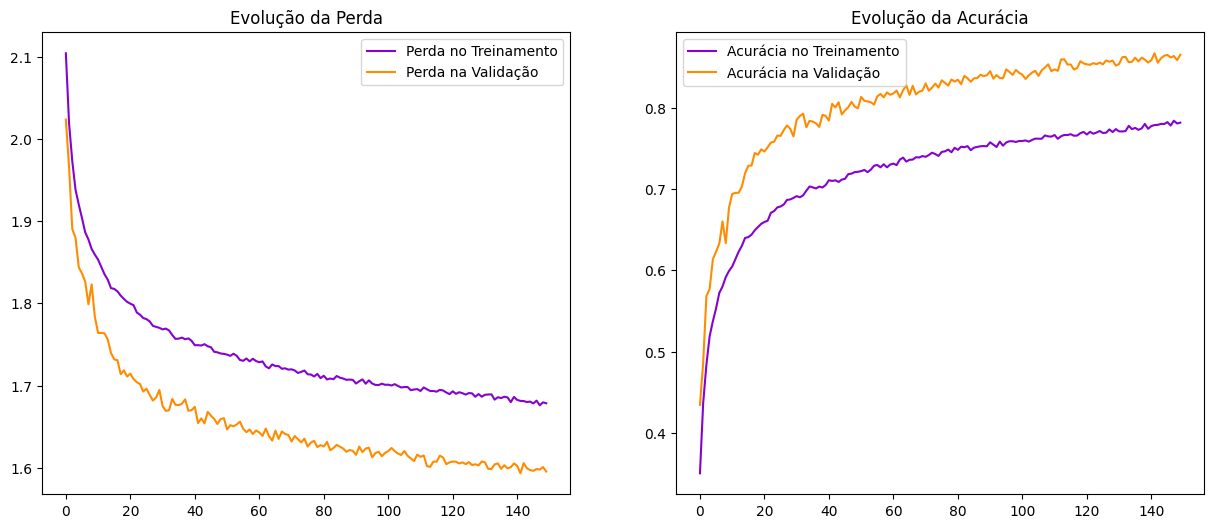

In [12]:
plt.figure(figsize=(15, 6))

# Plotando a perda no treinamento e validação
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Perda no Treinamento', color='#8502d1')
plt.plot(val_loss_history, label='Perda na Validação', color='darkorange')
plt.legend()
plt.title('Evolução da Perda')

# Plotando a acurácia no treinamento e validação
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Acurácia no Treinamento', color='#8502d1')
plt.plot(val_acc_history, label='Acurácia na Validação', color='darkorange')
plt.legend()
plt.title('Evolução da Acurácia')

plt.show()

---
## Avaliação do Modelo nos Dados de Teste

In [13]:
# Coloca o modelo em modo de avaliação
model.eval()

# Desabilita o cálculo de gradientes, já que não vamos precisar para avaliação
with torch.no_grad():
    test_loss = 0.0
    correct_preds = 0
    total_preds = 0

    # Loop pelos dados de teste
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Passa os dados pelo modelo
        outputs = model(inputs)
        
        # Calcula a perda
        loss = criterion(outputs, labels)
        test_loss += loss.item() * inputs.size(0)
        
        # Calcula as previsões
        _, predicted = torch.max(outputs, 1)
        
        # Conta o número de acertos
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

# Calcula a perda média e a acurácia
test_loss /= len(testloader.dataset)
test_acc = correct_preds / total_preds

print('\nAcurácia no Teste:', test_acc)
print('Perda no Teste:    ', test_loss)


Acurácia no Teste: 0.8468
Perda no Teste:     1.6144982131958008


### Predição

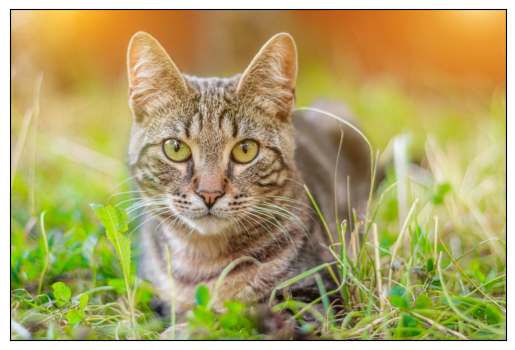

Forma do tensor de entrada: torch.Size([1, 3, 32, 32])
A classe predita é: cat


In [14]:
import urllib.request
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch

# URL da imagem
url = "https://inovaveterinaria.com.br/wp-content/uploads/2015/04/gato-sem-raca-INOVA-1024x683.jpg"

# Baixa a imagem da URL
resp = urllib.request.urlopen(url)

# Converte a imagem para um array de bytes
image = np.asarray(bytearray(resp.read()), dtype="uint8")

# Decodifica os bytes da imagem
image = cv2.imdecode(image, cv2.IMREAD_UNCHANGED)

# Converte a imagem de BGR para RGB (por padrão, o OpenCV usa BGR)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Exibe a imagem
plt.imshow(image)
plt.xticks([])  # Remover as marcações do eixo x
plt.yticks([])  # Remover as marcações do eixo y
plt.grid(False)  # Remover a grade
plt.show()

# Redimensionar a imagem para 32x32 pixels
image_resized = cv2.resize(image, (32, 32))

# Normalizar a imagem (subtraindo a média e dividindo pelo desvio padrão)
# Aqui, usamos a média e o desvio padrão típicos do CIFAR-10
mean = np.array([0.4914, 0.4822, 0.4465])  # Valores médios do CIFAR-10
std = np.array([0.2470, 0.2435, 0.2616])   # Desvio padrão do CIFAR-10

image_normalized = (image_resized - mean) / (std + 1e-7)

# Alterar a ordem dos eixos para CHW (Canais, Altura, Largura)
image_transposed = np.transpose(image_normalized, (2, 0, 1))

# Converter a imagem para tensor e adicionar dimensão de lote (batch size = 1)
image_tensor = torch.tensor(image_transposed, dtype=torch.float32).unsqueeze(0)

# Exibir a forma do tensor de entrada
print(f"Forma do tensor de entrada: {image_tensor.shape}")

# Fazer a previsão
with torch.no_grad():
    prediction = model(image_tensor)  # Predição do modelo
    predicted_class = torch.argmax(prediction, dim=1).item()  # Classe predita

# Definir os nomes das classes (ajuste conforme o seu caso)
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Exibir o resultado
print(f"A classe predita é: {class_names[predicted_class]}")